 1. Construct a Social Network
 2. Define parameters and rules. Explain choice of values
 3. Implement an epidemic spread
 4. How will you incoporate quarantining in this network 
     - show impact of quarantining
 5. How will you implement vaccination in this network
     - show why your strategy is better than some other strategy

### Notes:
1. Covid $R_0$ = 2.5 (https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html)
2. Network to use = Watts-Strogatz. 
    - Need a small-world network with groups of high clustering coefficients to simulate families..
    - VS Erdos-Renyi: ER model doesn't take into account clustering coefficient and an ER model tends to be very low. Also, it doesn't closely simulate real-world networks as degree distribution doesn't follow power law.
    - VS Barabasi-Albert: 2nd best network to consider, as it takes into account hubs or super-spreaders in a network. For this epidemic modelling though, we won't need hubs. Just some random infected nodes.
3. Vaccination, what does it mean? Removing from network? or just in network but not `S` anymore? The answer: remove from network. **Lev, T., Shmueli, E. State-based targeted vaccination. Appl Netw Sci 6, 6 (2021). https://doi.org/10.1007/s41109-021-00352-z**
4. SIR model = https://guava.physics.uiuc.edu/~nigel/courses/563/Essays_2005/PDF/chen.pdf. For simplicity and for trying to replicate the characteristics of Covid, use SI model.
5. Python implementation https://python.plainenglish.io/visualizing-dynamic-phenomena-with-sir-model-and-networks-45a4e629e609
6. Vaccination - random, targeted, then state-based
7. Epidemics on Networks - https://arxiv.org/pdf/2001.02436.pdf

---

# Epidemic Spread, Vaccination and Other Prevention Strategies: Modelling an Epidemic via Network Analysis

### Constructing a Social Network

*Explanation*
- purpose of epidemic spread modelling
- why watts strogatz


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import collections
import names as n
import community
import EoN
from random import choice

sns.set(style="darkgrid", context="talk")

In [2]:
G = nx.watts_strogatz_graph(100, 4, 0.5, seed=1)

In [3]:
weights = [random.random() for weight in range(G.number_of_edges())]

norm_weights = [i/max(weights) for i in weights]

k=0
for i, j in G.edges():
    G[i][j]['weight'] = norm_weights[k]
    k+=1
    
edge_widths = [data['weight'] for (source, target, data) in G.edges(data=True)]


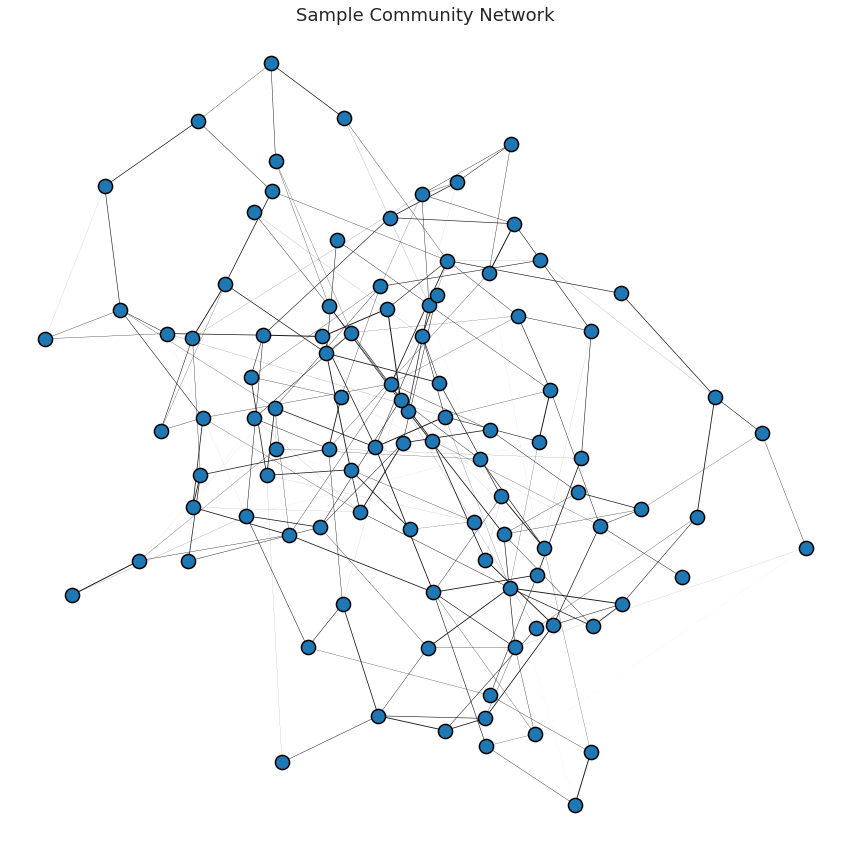

In [4]:
plt.figure(figsize=(15,15))
plt.axis('off')
pos = nx.spring_layout(G, k = 0.2, seed=1)
nx.draw_networkx(G, pos = pos, cmap = plt.cm.RdYlBu, 
                node_size = 200, with_labels = False, width = edge_widths)
ax = plt.gca()
ax.collections[0].set_edgecolor("black")

plt.title('Sample Community Network')
plt.show()

### Setting Infected People

*Explanation*
- 10 % of population are infected
- describe codes

In [5]:
#No attributes yet
G.nodes(data=True)

NodeDataView({0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}, 51: {}, 52: {}, 53: {}, 54: {}, 55: {}, 56: {}, 57: {}, 58: {}, 59: {}, 60: {}, 61: {}, 62: {}, 63: {}, 64: {}, 65: {}, 66: {}, 67: {}, 68: {}, 69: {}, 70: {}, 71: {}, 72: {}, 73: {}, 74: {}, 75: {}, 76: {}, 77: {}, 78: {}, 79: {}, 80: {}, 81: {}, 82: {}, 83: {}, 84: {}, 85: {}, 86: {}, 87: {}, 88: {}, 89: {}, 90: {}, 91: {}, 92: {}, 93: {}, 94: {}, 95: {}, 96: {}, 97: {}, 98: {}, 99: {}})

In [6]:
nx.set_node_attributes(G, 0, 'S')
nx.set_node_attributes(G, 0, 'I')
nx.set_node_attributes(G, 0, 'R')
nx.set_node_attributes(G, 0, 'Q')
nx.set_node_attributes(G, 0, 'V')

In [7]:
for i in range(int(G.number_of_edges()*0.1)):
    G.nodes(data=True)[choice(list(G.nodes))]['I'] = 1

In [8]:
infected = sum([value for key, value in nx.get_node_attributes(G,'I').items()])

In [9]:
# print(there are {} infected people', infected)

In [10]:
#https://www.javaer101.com/en/article/12785882.html
node_color = []
node_size = []
for nodes in G.nodes(data=True):
    if nodes[1]['I'] == 1:
        node_color.append('#DC143C')
        node_size.append(200*2.5)
    else:
        node_color.append('#4169E1')
        node_size.append(200)

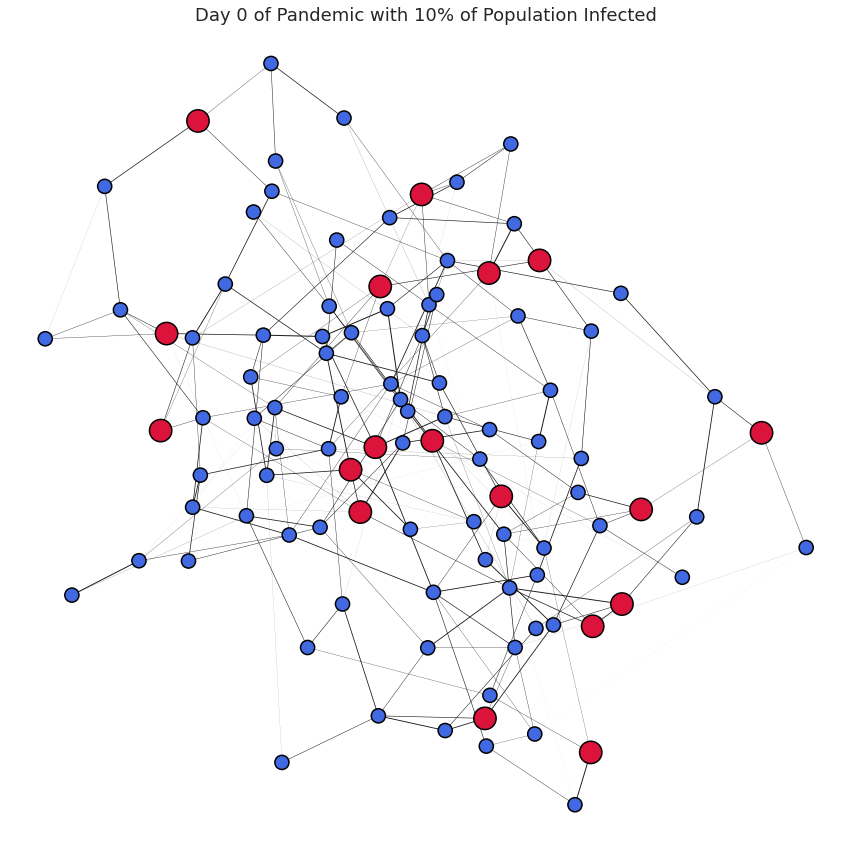

In [11]:
plt.figure(figsize=(15,15))
plt.axis('off')
pos = nx.spring_layout(G, k = 0.2, seed=1)
nx.draw_networkx(G, pos = pos, node_color=node_color, 
                node_size = node_size, with_labels = False, 
                 width = edge_widths)
ax = plt.gca()
ax.collections[0].set_edgecolor("black")

plt.title('Day 0 of Pandemic with 10% of Population Infected')
plt.show()

### Epidemic Spread

*Explanation*
- rate of infection = similar to covid
- 2 out of 3 people per individual chance of infection

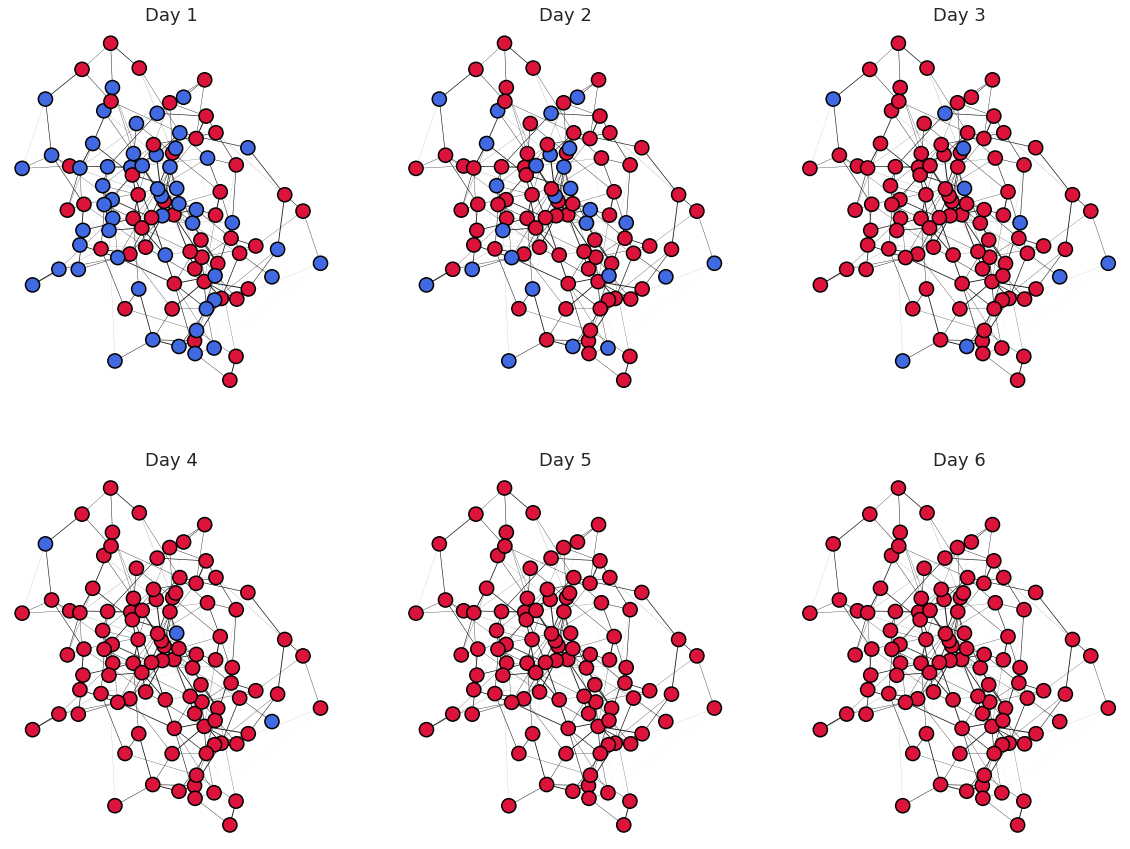

In [12]:
#https://github.com/eflegara/Network-Science-Lectures/blob/master/Exploring%20Social%20Distancing.ipynb
# pos = nx.spring_layout(G, k = 0.2, seed=1)
fig = plt.figure(figsize=(20,15));
G1 = G.copy()

initial = [infected]
# num_of_infected()

for i in range(6):
    for nodes in G1.nodes(data=True):
        if nodes[1]['I'] == 1:
            for edge in G1.edges(nodes[0]):
                if random.random() > 0.66:
                    G1.nodes(data=True)[edge[1]]['I'] = 1
                    
    initial.append((sum([value for key, value in 
                            nx.get_node_attributes(G1,'I').items()])))
    node_color = []
    node_size = []
    for nodes in G1.nodes(data=True):
        if nodes[1]['I'] == 1:
            node_color.append('#DC143C')
            node_size.append(200)
        else:
            node_color.append('#4169E1')
            node_size.append(200)


    ax = fig.add_subplot(2, 3, i+1);
    
    plt.axis('off')
    nc = nx.draw_networkx(G1, 
                     pos = pos, 
                     node_color=node_color, 
                     node_size = node_size, 
                     with_labels = False, 
                     width = edge_widths, 
                     )
    ax = plt.gca()
    ax.collections[0].set_edgecolor("black")

    plt.title('Day {}'.format(i+1))
plt.savefig('epidemics.jpg')
plt.show()

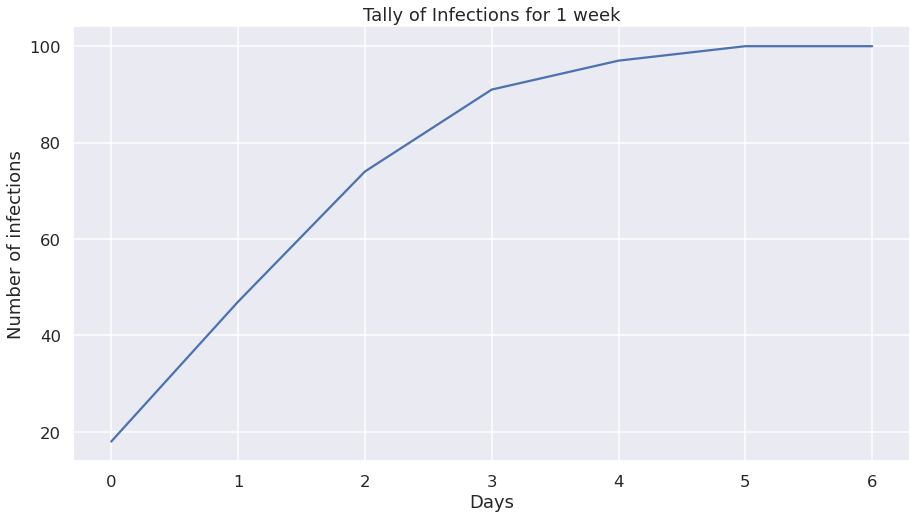

In [13]:
plt.figure(figsize=(15,8))
sns.lineplot(x=range(len(initial)), y=initial)
plt.xlabel('Days')
plt.ylabel('Number of infections')
plt.title('Tally of Infections for 1 week');

*Explanation about graph*

### Quarantine

*Explanation*
- what is quarantine
- for this implementation, quarantine is:
    - after infection, quarantine. but, there is still chance to infection. 
    - in the next sequence, quarantined individuals have 0% infection chance

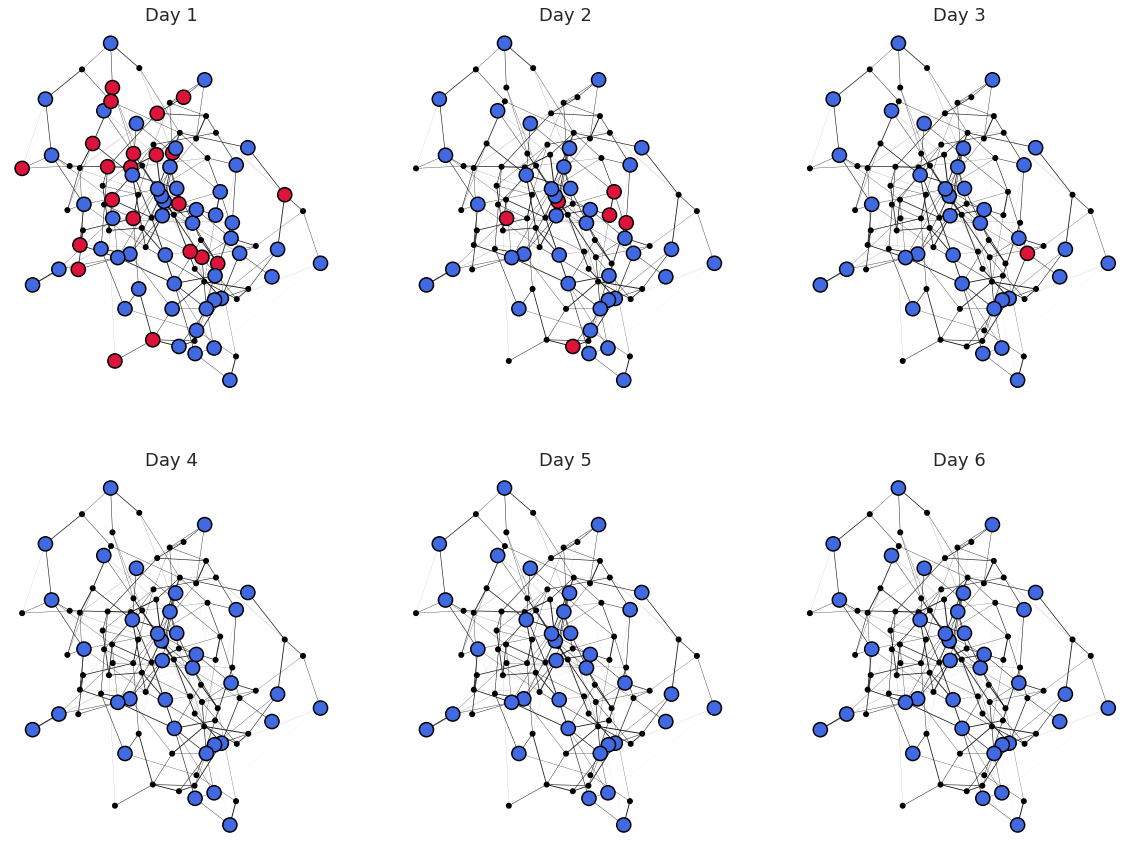

In [14]:
#https://github.com/eflegara/Network-Science-Lectures/blob/master/Exploring%20Social%20Distancing.ipynb
# pos = nx.spring_layout(G, k = 0.2, seed=1)
fig = plt.figure(figsize=(20,15));
G2 = G.copy()
q_initial = [infected]
quarantined = [0]
pos1 = nx.spring_layout(G2, k = 0.2, seed=1)

for i in range(6):
    for nodes in G2.nodes(data=True):
        if nodes[1]['I'] == 1:
            if nodes[1]['Q'] == 0:
                for edge in G2.edges(nodes[0]):
                    if random.random() > 0.66:
                        G2.nodes(data=True)[edge[1]]['I'] = 1
            G2.nodes(data=True)[nodes[0]]['Q'] = 1 
            G2.nodes(data=True)[nodes[0]]['I'] = 0 
                
    q_initial.append((sum([value for key, value in 
                            nx.get_node_attributes(G2,'I').items()])))
                
    quarantined.append((sum([value for key, value in 
                            nx.get_node_attributes(G2,'Q').items()])))
    
    
    node_color = []
    node_size = []
    for nodes in G2.nodes(data=True):
        if nodes[1]['Q'] == 1:
            node_color.append('black')
            node_size.append(20)
        elif nodes[1]['R'] == 1:
            node_color.append('green')
            node_size.append(200)
        elif nodes[1]['I'] == 1:
            node_color.append('#DC143C')
            node_size.append(200)
        else:
            node_color.append('#4169E1')
            node_size.append(200)
#         print(nodes)
    ax = fig.add_subplot(2, 3, i+1);
    
    plt.axis('off')
    nc = nx.draw_networkx(G2, 
                     pos = pos1, 
                     node_color=node_color, 
                     node_size = node_size, 
                     with_labels = False, 
                     width = edge_widths 
                     )
    ax = plt.gca()
    ax.collections[0].set_edgecolor("black")
    plt.title('Day {}'.format(i+1))
plt.show()

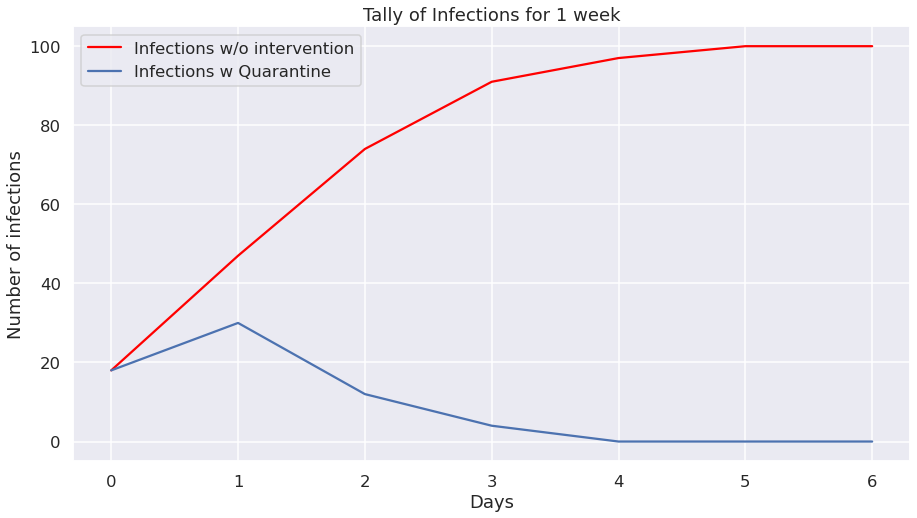

In [15]:
plt.figure(figsize=(15,8))

sns.lineplot(x=range(len(initial)), 
             y=initial, 
             label = 'Infections w/o intervention', 
             color = 'red')

sns.lineplot(x=range(len(q_initial)), 
             y=q_initial, 
             label = 'Infections w Quarantine')


plt.xlabel('Days')
plt.ylabel('Number of infections')
plt.legend()
plt.title('Tally of Infections for 1 week');

*Explanation about graph*

### Vaccination

### 1. Random Vaccination (Selecting Random Nodes to Vaccinate)
#### Vaccine with 98% efficacy.

*Explanation*
- Pfizer vaccine, 98% efficacy. Used in this simulation

In [16]:
#https://github.com/eflegara/Network-Science-Lectures/blob/master/Exploring%20Social%20Distancing.ipynb
# pos = nx.spring_layout(G, k = 0.2, seed=1)

def random_vacc(num):
    '''
    Create vaccination simulation
    
    Parameters:
    num : float
        percentage of people vaccinated
    '''
    fig = plt.figure(figsize=(20,15));

    H = G.copy()

    for i in range(int(H.number_of_edges()*num)):
        H.nodes(data=True)[choice(list(G.nodes))]['V'] = 1

    G3 = H.copy()

    initial = [infected]
    vaccinated = [0]
    not_infected = [0]
    # num_of_infected()

    for i in range(6):

        for nodes in G3.nodes(data=True):
            if nodes[1]['I'] == 1:
                for edge in G3.edges(nodes[0]):
                    if (G3.nodes(data=True)[edge[1]]['V'] == 1):
                        if random.random() > 0.98:
                            G3.nodes(data=True)[edge[1]]['I'] = 1
                    else:
                        if random.random() >= 0.66:
                            G3.nodes(data=True)[edge[1]]['I'] = 1


        initial.append((sum([value for key, value in 
                                nx.get_node_attributes(G3,'I').items()])))
        vaccinated.append((sum([value for key, value in 
                                nx.get_node_attributes(G3,'V').items()])))
        not_infected.append((100 - sum([value for key, value in 
                                nx.get_node_attributes(G3,'I').items()])))


        node_color = []
        node_size = []
        for nodes in G3.nodes(data=True):
            if nodes[1]['V'] == 1:
                node_color.append('green')
                node_size.append(100)
            elif nodes[1]['I'] == 1:
                node_color.append('#DC143C')
                node_size.append(200)
            else:
                node_color.append('#4169E1')
                node_size.append(200)


        ax = fig.add_subplot(2, 3, i+1);

        plt.axis('off')
        nc = nx.draw_networkx(G3, 
                         pos = pos, 
                         node_color=node_color, 
                         node_size = node_size, 
                         with_labels = False, 
                         width = edge_widths, 
                         )
        ax = plt.gca()
        ax.collections[0].set_edgecolor("black")

        plt.title('Day {}'.format(i+1))
    plt.savefig('epidemics.jpg')
    plt.show()
    return initial, vaccinated, not_infected

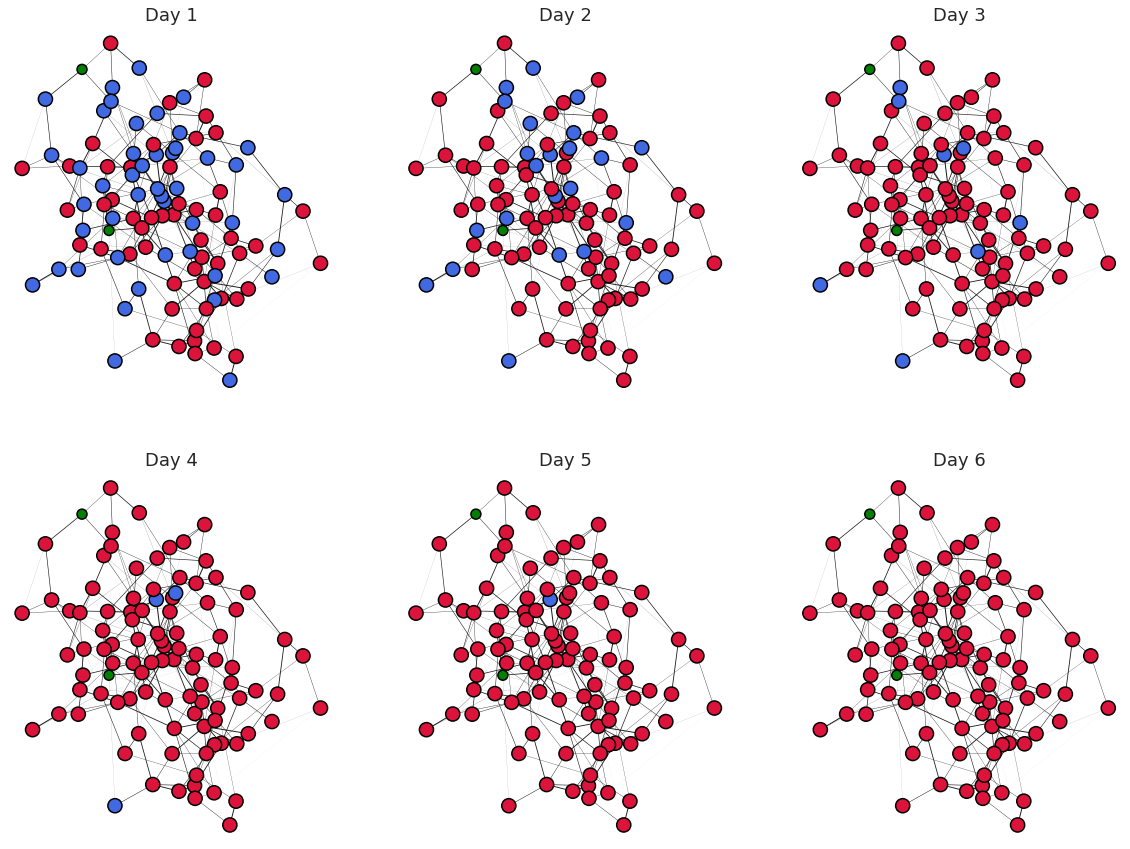

In [17]:
i1, v1, n1 = random_vacc(0.01)

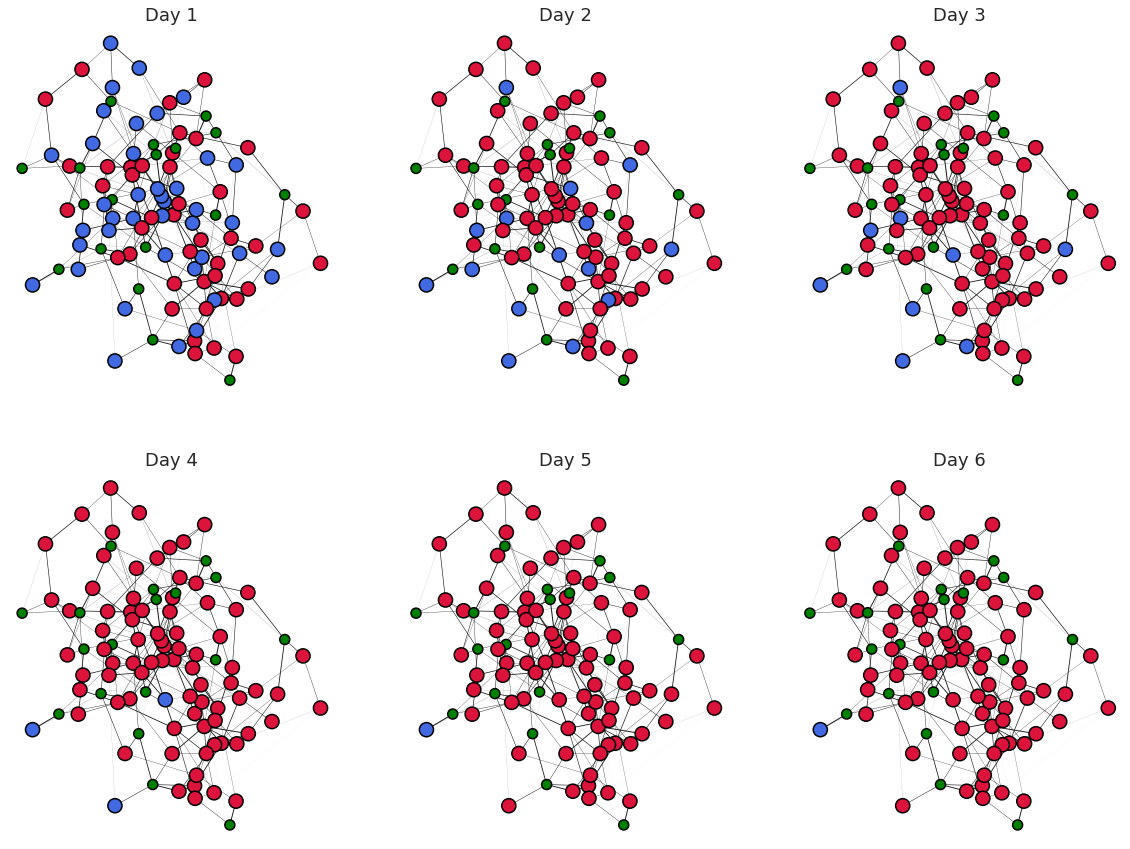

In [18]:
i2, v2, n2 = random_vacc(0.1)

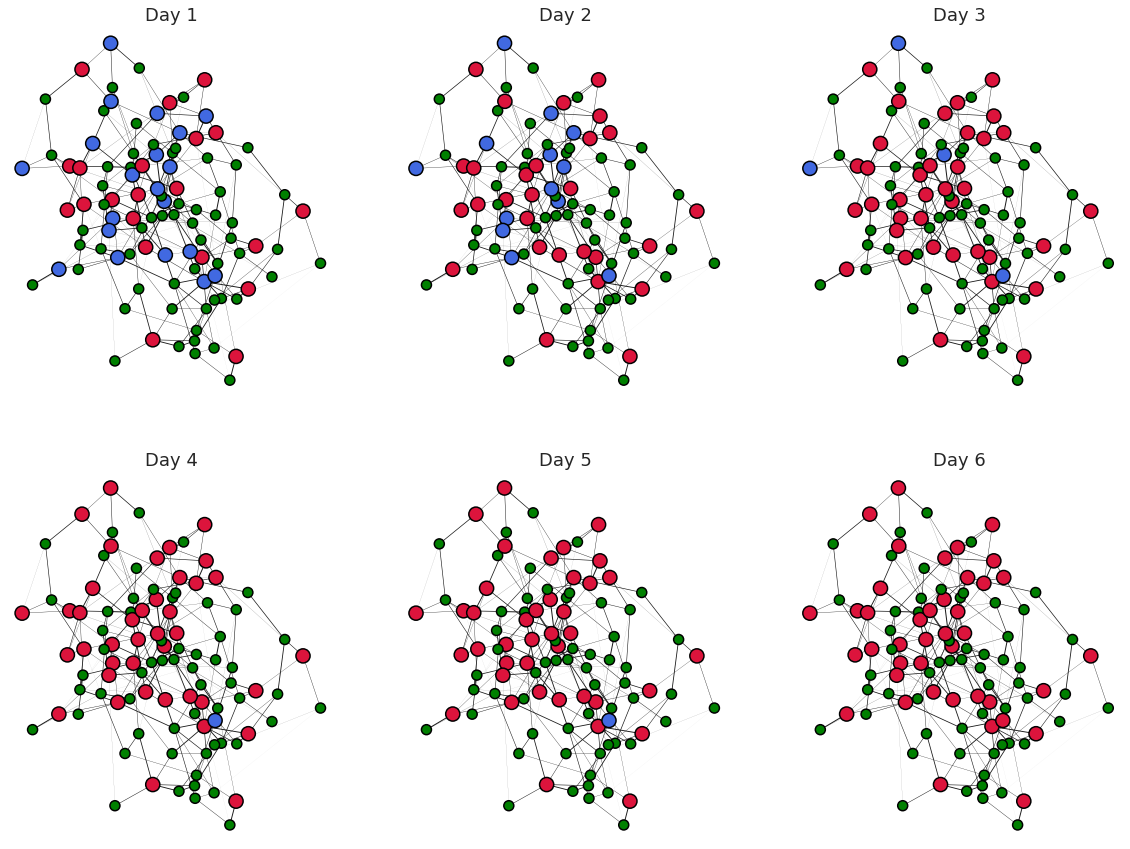

In [19]:
i3, v3, n3 = random_vacc(0.5)

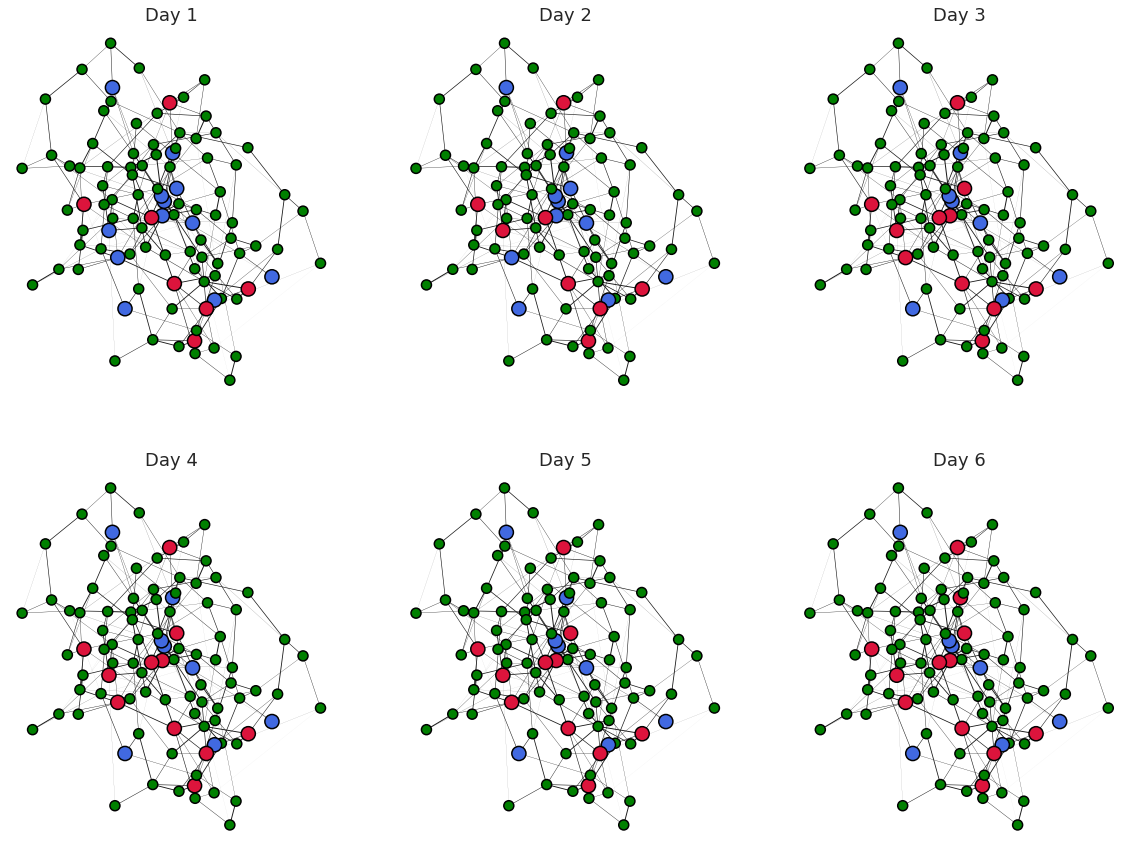

In [20]:
i4, v4, n4 = random_vacc(0.8)

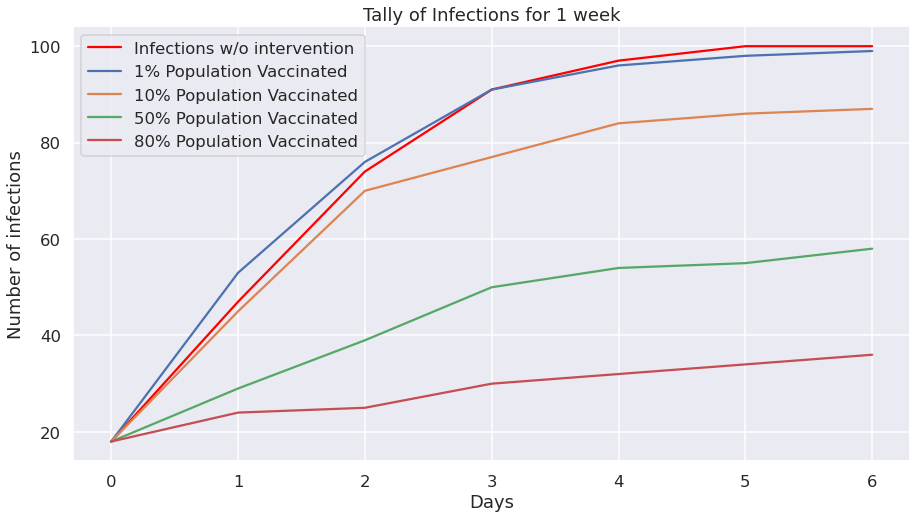

In [21]:
plt.figure(figsize=(15,8))

sns.lineplot(x=range(len(initial)), 
             y=initial, 
             label = 'Infections w/o intervention', 
             color = 'red')

sns.lineplot(x=range(len(i1)), 
             y=i1, 
             label = '1% Population Vaccinated')

sns.lineplot(x=range(len(i2)), 
             y=i2, 
             label = '10% Population Vaccinated')


sns.lineplot(x=range(len(i3)), 
             y=i3, 
             label = '50% Population Vaccinated')


sns.lineplot(x=range(len(i4)), 
             y=i4, 
             label = '80% Population Vaccinated')


plt.xlabel('Days')
plt.ylabel('Number of infections')
plt.legend()
plt.title('Tally of Infections for 1 week');

*Explanation about graph*

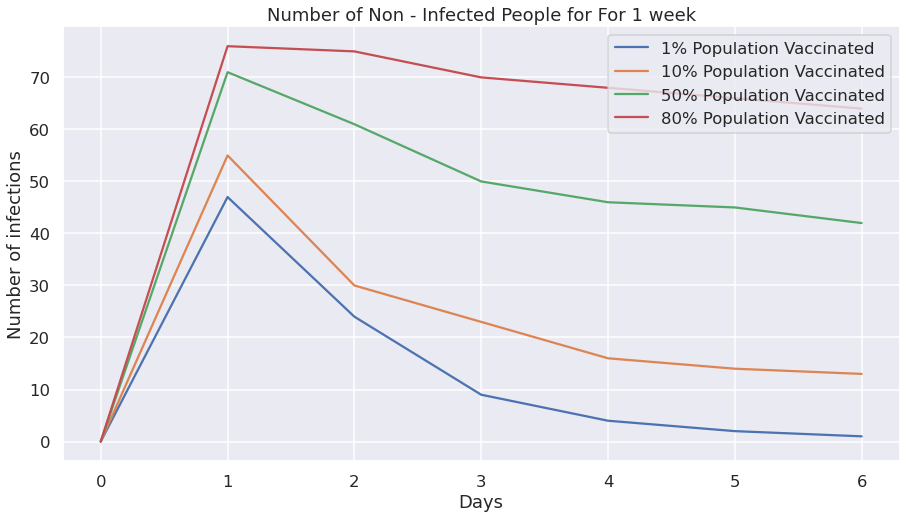

In [22]:
plt.figure(figsize=(15,8))

sns.lineplot(x=range(len(n1)), 
             y=n1, 
             label = '1% Population Vaccinated')

sns.lineplot(x=range(len(n2)), 
             y=n2, 
             label = '10% Population Vaccinated')


sns.lineplot(x=range(len(n3)), 
             y=n3, 
             label = '50% Population Vaccinated')


sns.lineplot(x=range(len(n4)), 
             y=n4, 
             label = '80% Population Vaccinated')


plt.xlabel('Days')
plt.ylabel('Number of infections')
plt.legend()
plt.title('Number of Non - Infected People for For 1 week');

*Explanation about graph*

### Targeted Vaccination

*Explanation*
- chosen nodes are vaccinated.
- chosen nodes based on closeness centrality. Why? Closeness centrality is the reciprocal sum of shortest distances to the node. degree centrality is not used because it is a random network built on at least 3 nodes. so each node will have either 2 or 3 edges. Eigenvector and betweenness have low value

In [23]:
degree = list(nx.degree_centrality(G).values())
closeness = list(nx.closeness_centrality(G).values())
betweenness = list(nx.betweenness_centrality(G).values())
eigenvector = list(nx.eigenvector_centrality(G).values())

In [24]:
centralities = [degree, closeness, betweenness, eigenvector]

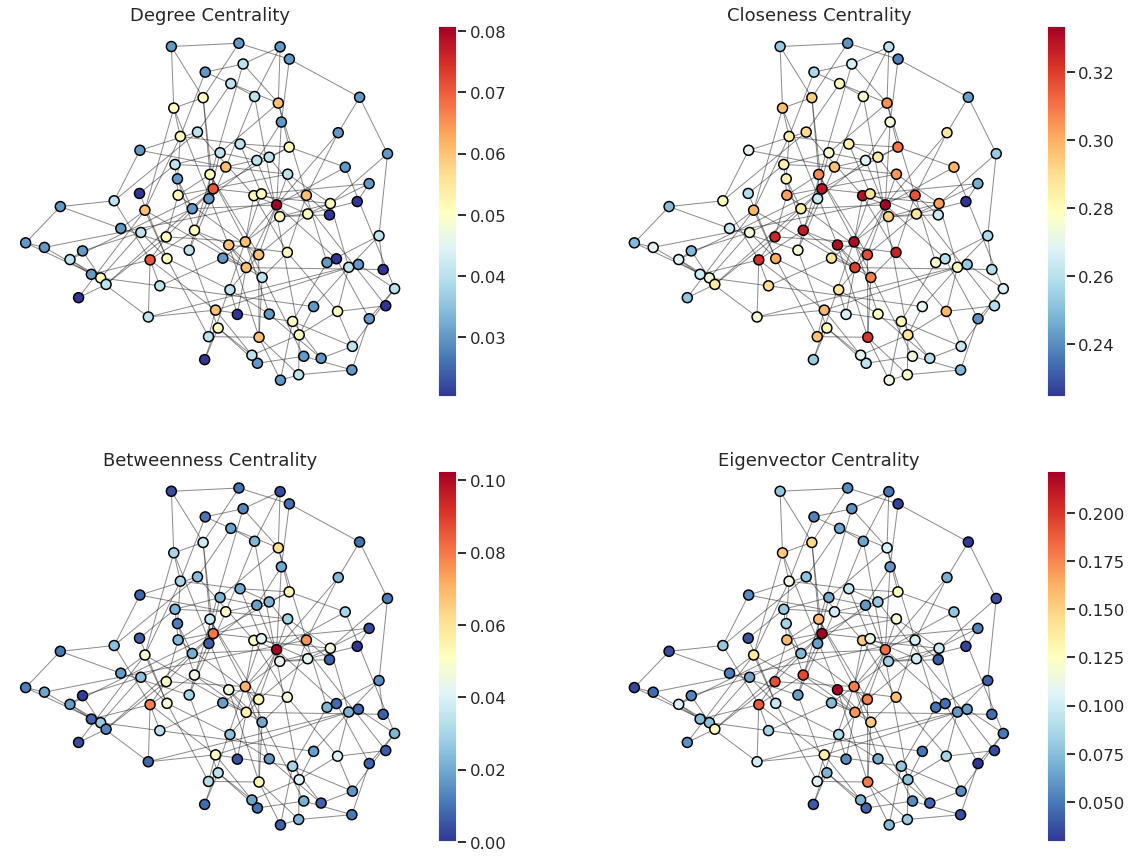

In [25]:
fig = plt.figure(figsize=(20,15));

titles = ['Degree Centrality', 'Closeness Centrality', 
          'Betweenness Centrality', 'Eigenvector Centrality']

pos = nx.spring_layout(G, k=0.18)

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1);
    nc = nx.draw_networkx_nodes(G, pos, 
                            node_size=100, cmap=plt.cm.RdYlBu_r,
                            node_color=centralities[i]);
    nx.draw_networkx_edges(G, pos, alpha=0.500);
    plt.title(titles[i]);
    plt.axis('off');
    plt.colorbar(nc);
    
    ax = plt.gca()
    ax.collections[0].set_edgecolor("black")

plt.show()

In [26]:
#https://github.com/eflegara/Network-Science-Lectures/blob/master/Exploring%20Social%20Distancing.ipynb
# pos = nx.spring_layout(G, k = 0.2, seed=1)

def choice_vacc(num):
    '''
    Create vaccination simulation based on closeness centrality
    
    Parameters:
    num : int
        number of people vaccinated based on closeness centrality
    '''
    fig = plt.figure(figsize=(20,15));

    H = G.copy()
    top = list(sorted(nx.closeness_centrality(H).items(), 
                     key=lambda x: -x[1]))[:num]
    top = [i[0] for i in top]
    
    for i in top:
        H.nodes(data=True)[i]['V'] = 1

    G3 = H.copy()

    initial = [infected]
    vaccinated = [0]
    not_infected = [0]
    # num_of_infected()

    for i in range(6):

        for nodes in G3.nodes(data=True):
            if nodes[1]['I'] == 1:
                for edge in G3.edges(nodes[0]):
                    if (G3.nodes(data=True)[edge[1]]['V'] == 1):
                        if random.random() > 0.98:
                            G3.nodes(data=True)[edge[1]]['I'] = 1
                    else:
                        if random.random() >= 0.66:
                            G3.nodes(data=True)[edge[1]]['I'] = 1


        initial.append((sum([value for key, value in 
                                nx.get_node_attributes(G3,'I').items()])))
        vaccinated.append((sum([value for key, value in 
                                nx.get_node_attributes(G3,'V').items()])))
        not_infected.append((100 - sum([value for key, value in 
                                nx.get_node_attributes(G3,'I').items()])))


        node_color = []
        node_size = []
        for nodes in G3.nodes(data=True):
            if nodes[1]['V'] == 1:
                node_color.append('green')
                node_size.append(100)
            elif nodes[1]['I'] == 1:
                node_color.append('#DC143C')
                node_size.append(200)
            else:
                node_color.append('#4169E1')
                node_size.append(200)


        ax = fig.add_subplot(2, 3, i+1);

        plt.axis('off')
        nc = nx.draw_networkx(G3, 
                         pos = pos, 
                         node_color=node_color, 
                         node_size = node_size, 
                         with_labels = False, 
                         width = edge_widths, 
                         )
        ax = plt.gca()
        ax.collections[0].set_edgecolor("black")

        plt.title('Day {}'.format(i+1))
    plt.savefig('epidemics.jpg')
    plt.show()
    return initial, vaccinated, not_infected

#### Top 10 Nodes Based on Closeness Centrality

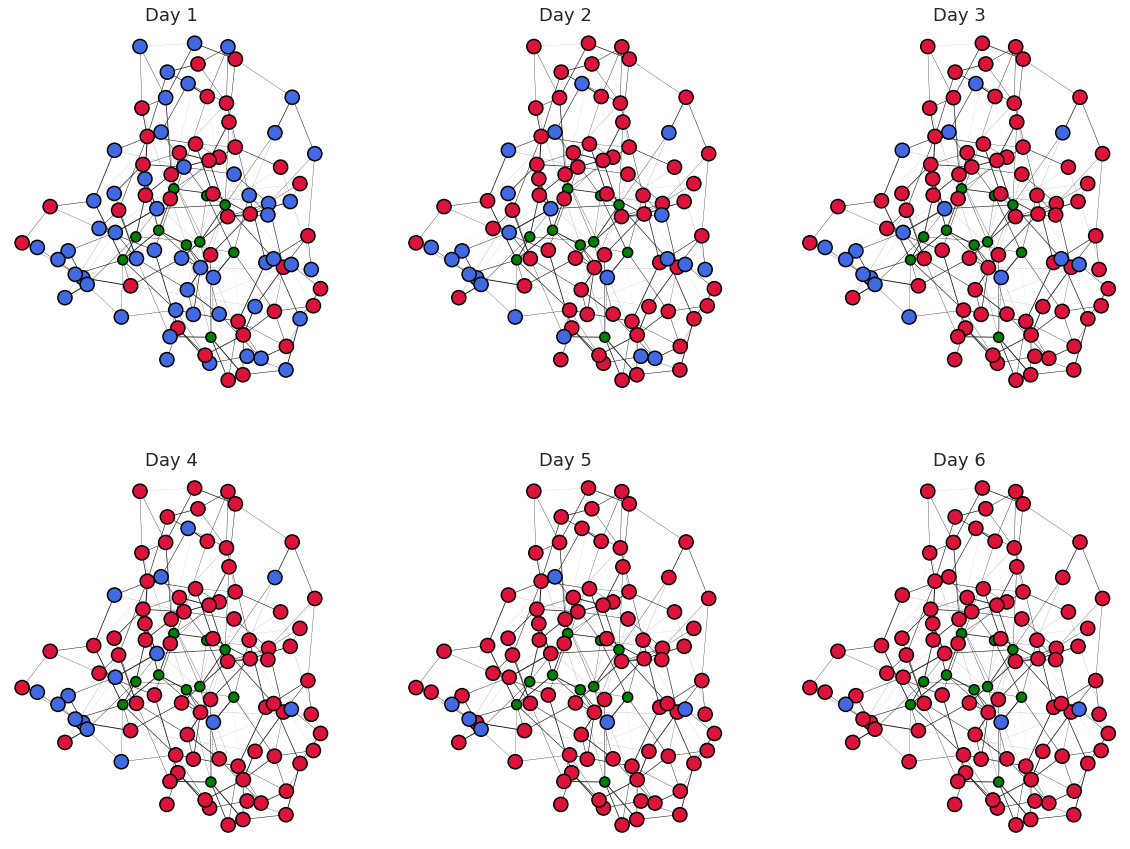

In [27]:
ci1, cv1, cn1 = choice_vacc(10)

#### Top 20 Nodes Based on Closeness Centrality

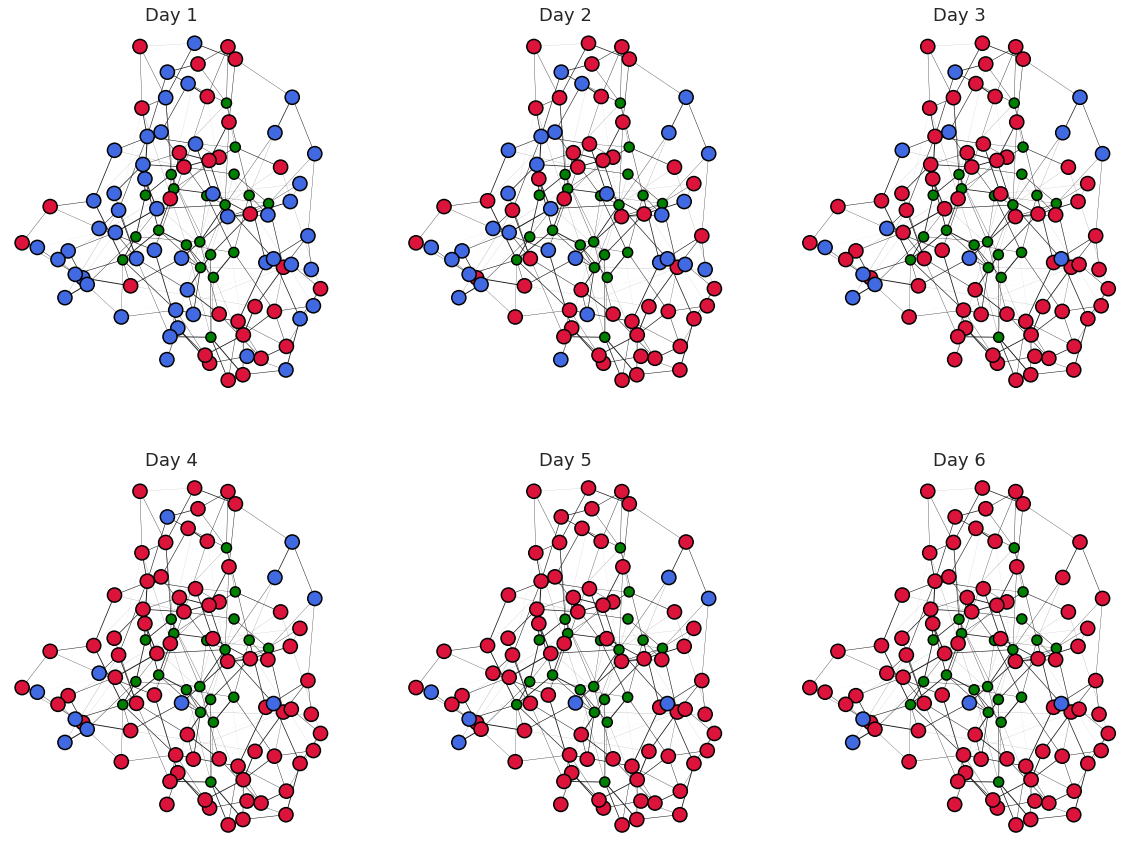

In [28]:
ci2, cv2, cn2 = choice_vacc(20)

#### Top 40 Nodes Based on Closeness Centrality

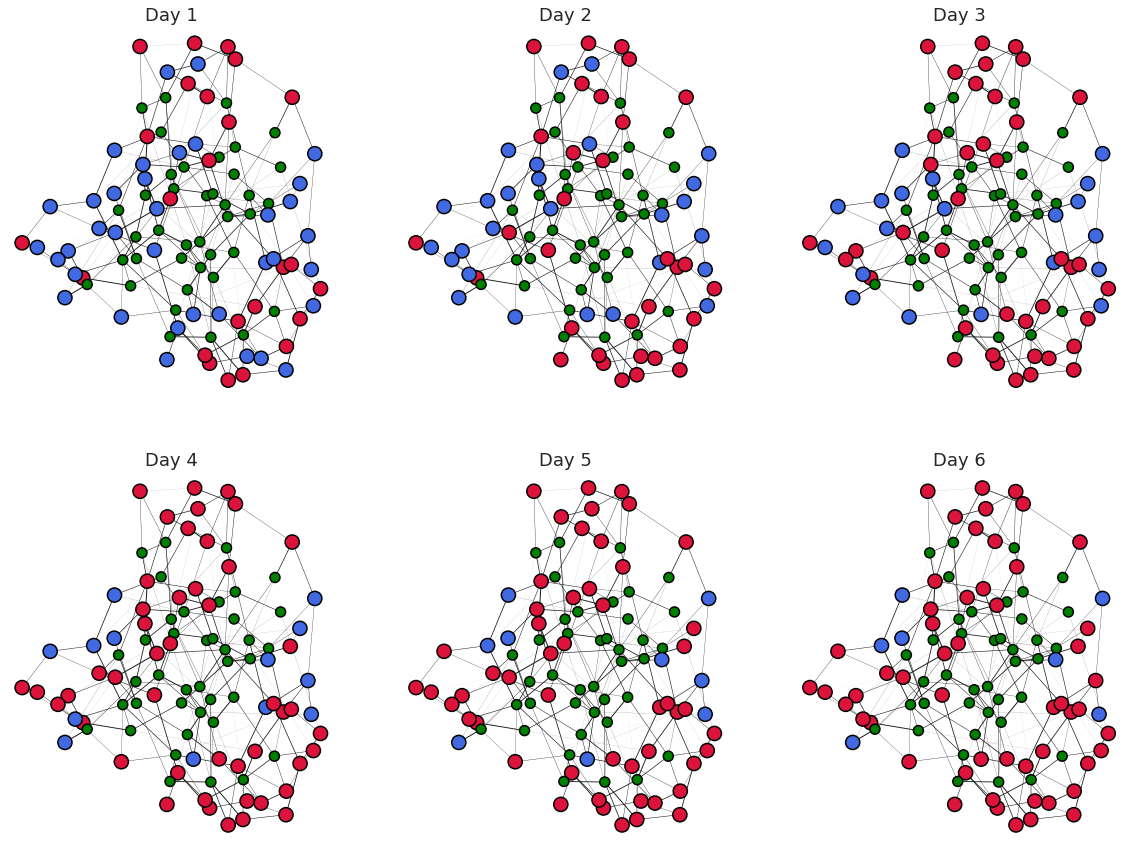

In [29]:
ci3, cv3, cn3 = choice_vacc(40)

#### Top 60 Nodes Based on Closeness Centrality

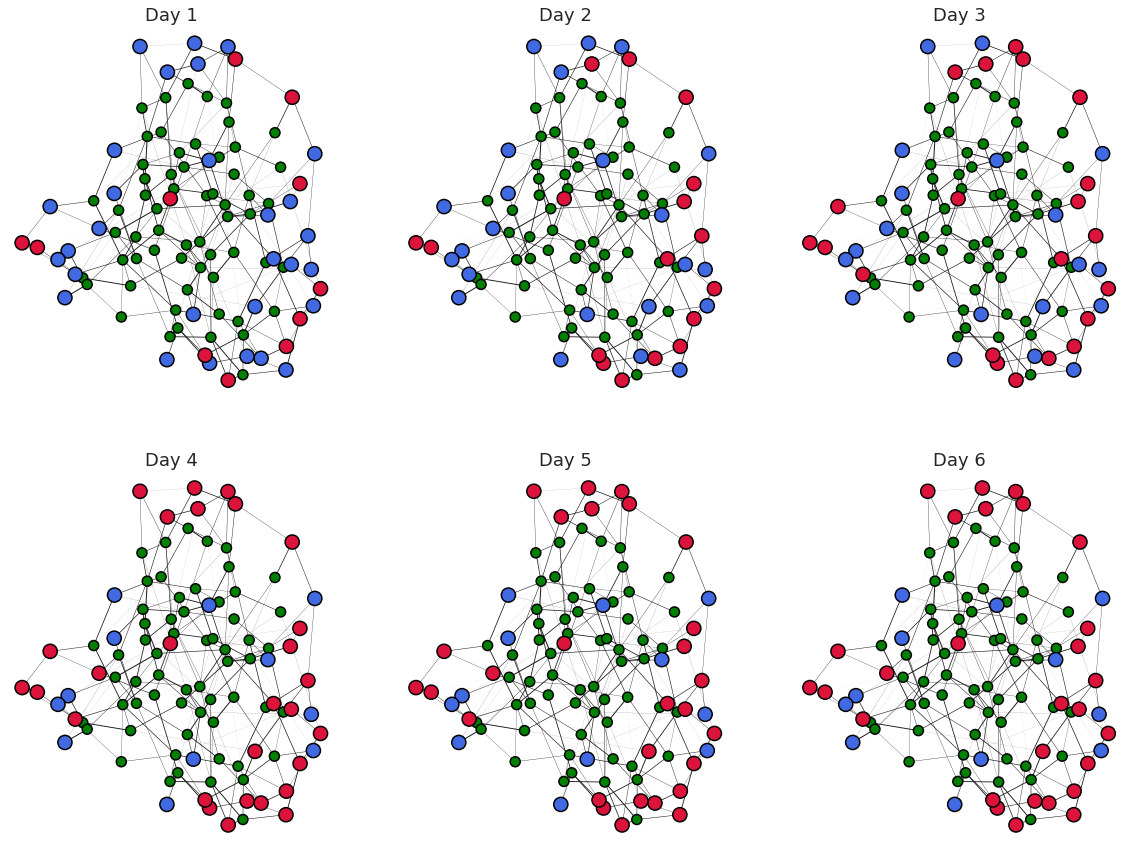

In [30]:
ci4, cv4, cn4 = choice_vacc(60)

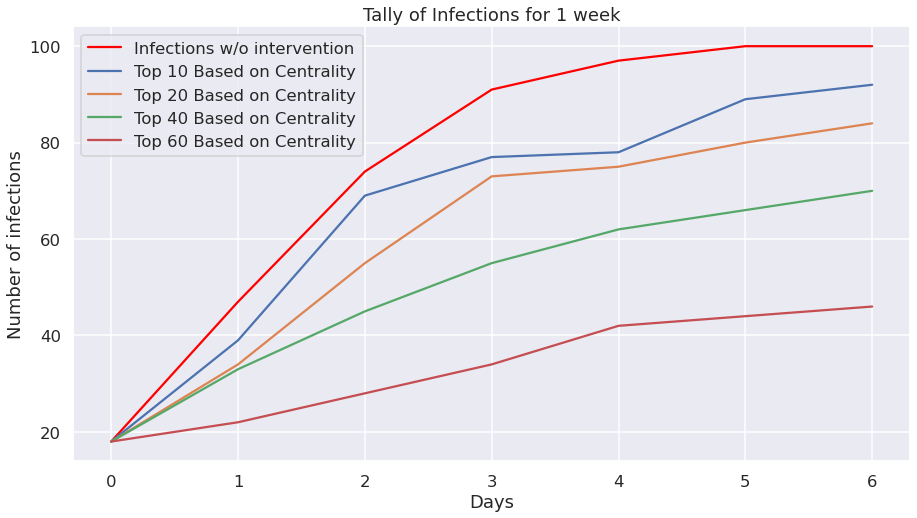

In [31]:
plt.figure(figsize=(15,8))

sns.lineplot(x=range(len(initial)), 
             y=initial, 
             label = 'Infections w/o intervention', 
             color = 'red')

sns.lineplot(x=range(len(ci1)), 
             y=ci1, 
             label = 'Top 10 Based on Centrality')

sns.lineplot(x=range(len(ci2)), 
             y=ci2, 
             label = 'Top 20 Based on Centrality')


sns.lineplot(x=range(len(ci3)), 
             y=ci3, 
             label = 'Top 40 Based on Centrality')


sns.lineplot(x=range(len(ci4)), 
             y=ci4, 
             label = 'Top 60 Based on Centrality')


plt.xlabel('Days')
plt.ylabel('Number of infections')
plt.legend()
plt.title('Tally of Infections for 1 week');

*Explanation of graph*

### Appendix: Epidemic Spread Simulation via EoN (Epidemics on Networks) Library

<Figure size 1080x1440 with 0 Axes>

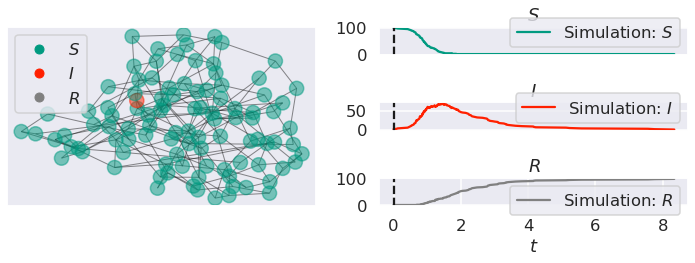

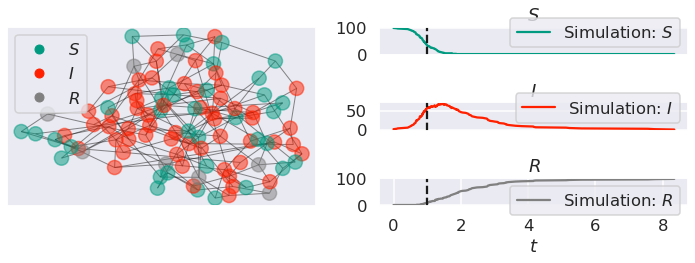

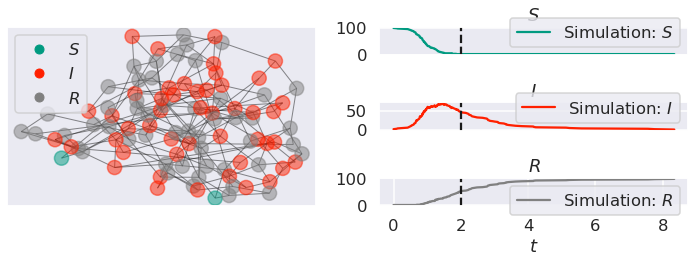

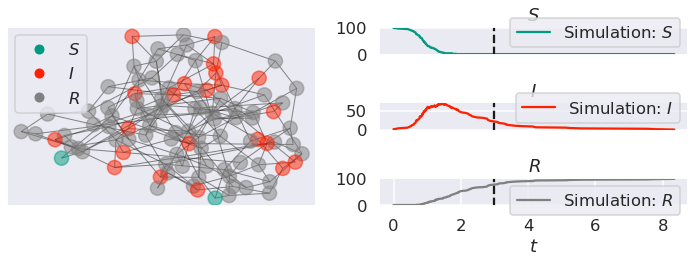

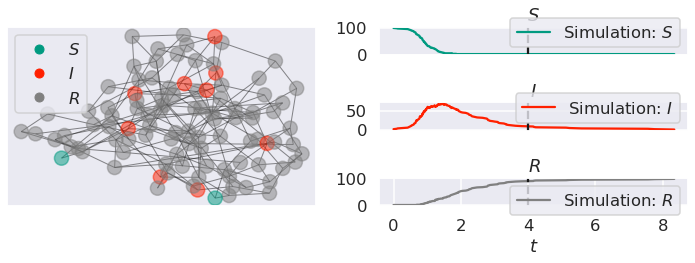

In [32]:
tau = 2
gamma = 0.8

simulation = EoN.fast_SIR(G, tau, gamma, initial_infecteds = 1, 
                         return_full_data = True)

nx_kwargs = {
    'pos':pos,
    'node_size': 200, 
    'alpha': 0.5
}
plt.figure(figsize=(15, 20))
# nx_kwargs = {"pos": pos, "alpha": 0.7}

for i in range(0, 5):
    ax = simulation.display(time = i, **nx_kwargs)
